In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import Normalize

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [2]:
n = 2000 # sample size
p = 100 # dimension
L = 200 # band size
mu_norm = 10

setting = "$n = {} \\quad p = {} \\quad L = {} \\quad \\| \\mu \\| = {}$".format(n, p, L, mu_norm)

c = p/n
epsilon = (2*L-1)/n

pm1_setting = False

if pm1_setting:
    k = 2 # number of classes
    pi = np.array([0.5, 0.5]) # proportion of each class
    mu = stats.norm.rvs(size=(p, 1))
    M = np.concatenate([+mu, -mu], axis=1)
else:
    k = 3 # number of classes
    pi = np.array([0.334, 0.333, 0.333]) # proportion of each class
    M = stats.norm.rvs(size=(p, k))

M = mu_norm*M/np.linalg.norm(M, axis=0) # centroid of each class
J = utils.getJ(n, pi)
nbMC = 1 # number of Monte-Carlo simulations

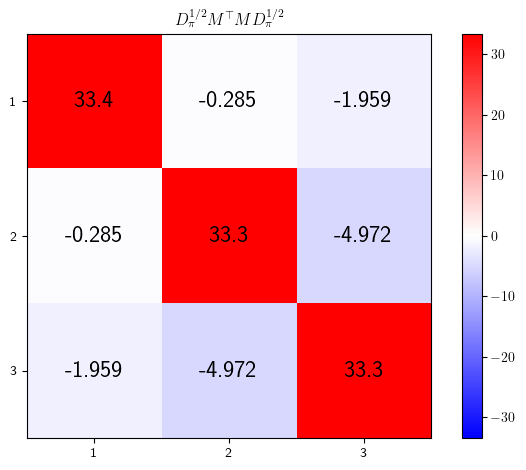

In [3]:
sim_classes = (M.T@M)*np.sqrt(pi[:, None]*pi[None, :])

norm_sup = np.abs(sim_classes).max()
norm = Normalize(-norm_sup, norm_sup)
fig, ax = plt.subplots()
im = ax.imshow(sim_classes, norm=norm, cmap='bwr')
fig.colorbar(im)
range_k = np.arange(k)
ax.set_xticks(range_k, labels=range_k+1)
ax.set_yticks(range_k, labels=range_k+1)
for i in range_k:
    for j in range_k:
        ax.text(j, i, np.round(sim_classes[i, j], 3), ha='center', va='center', size='xx-large')
ax.set_title("$D_\\pi^{1/2} M^\\top M D_\\pi^{1/2}$")
fig.tight_layout()
plt.show()

# Computations

**Limiting spectral distribution**: we use the fact that, if $m$ is the Stieltjes transform of a measure which has a density $d(x)$ in $x$, then
$$
d(x) = \frac{1}{\pi} \lim_{y \downarrow 0} \Im \left[ m(x + \mathrm{i} y) \right].
$$

In [4]:
# Simulations
eigvals_t, eigvecs_t = utils.simul(nbMC, L, M, J, mask='toeplitz', comp=False)
eigvals_c, eigvecs_c = utils.simul(nbMC, L, M, J, mask='circulant', comp=False)

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


In [5]:
# Get eigenbases
if ('computed_bases' not in locals()) or (computed_bases[0] != n) or (computed_bases[1] != L):
    tau, basis_t = utils.basis(n, L, kind='toeplitz')
    psi, basis_c = utils.basis(n, L, kind='circulant')
    computed_bases = (n, L)

In [6]:
# Limiting spectral distribution
axr = np.linspace(eigvals_c.min(), eigvals_c.max(), 200)
eta0_t = utils.eta0(axr, p, tau)
eta0_c = utils.eta0(axr, p, psi)
LSD_t = (1/(1-axr-eta0_t)).imag/np.pi
LSD_c = (1/(1-axr-eta0_c)).imag/np.pi

100%|██████████| 200/200 [00:00<00:00, 2243.80it/s]


In [7]:
# Get spikes and alignments
if pm1_setting:
    spikes_c, spikes_t = utils.get_spikes(n, p, L, mu_norm)
    spikes_idx_c, spikes_c, zeta_c, natural_idx_c = spikes_c
    spikes_idx_t, spikes_t, zeta_t, natural_idx_t = spikes_t

In [8]:
# Inverse Participation Ratio (eigenvector localization)
IPR_t = np.sum(eigvecs_t**4, axis=1)/(np.sum(eigvecs_t**2, axis=1)**2)
IPR_c = np.sum(eigvecs_c**4, axis=1)/(np.sum(eigvecs_c**2, axis=1)**2)

# Visualisation

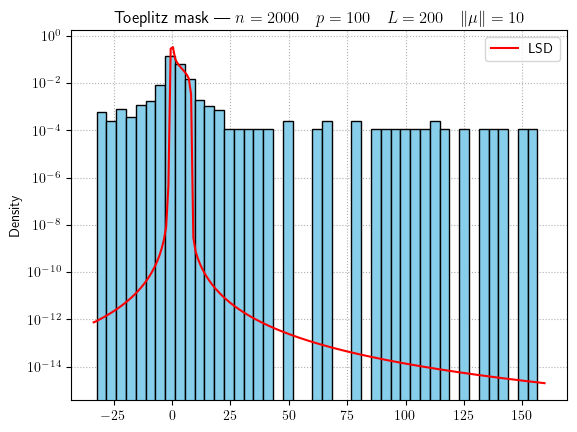

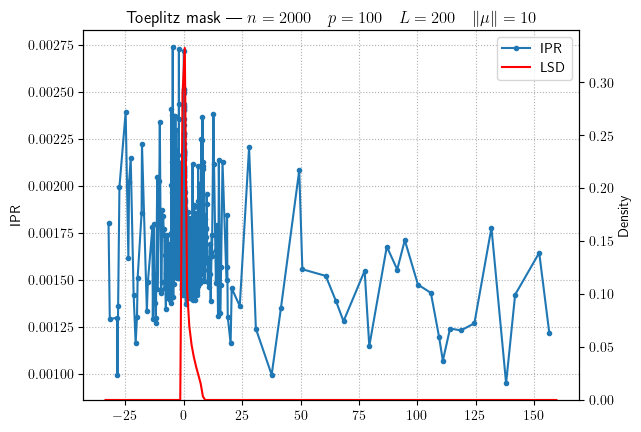

In [9]:
plt.hist(eigvals_t.flatten(), bins='sqrt', color='skyblue', edgecolor='black', density=True, zorder=2)
plt.plot(axr, LSD_t, color='red', label="LSD")
if pm1_setting:
    for spike in spikes_t:
        plt.axvline(x=spike, ls=':', color='green')
plt.grid(ls=':')
plt.yscale('log')
plt.ylabel("Density")
plt.legend()
plt.title("Toeplitz mask | "+setting)
plt.show()

plt.plot(eigvals_t[0], IPR_t[0], marker='.', label="IPR")
plt.grid(ls=':')
plt.ylabel("IPR")
ax1 = plt.gca()
ax2 = plt.twinx()
plt.plot(axr, LSD_t, color='red', label="LSD")
plt.ylabel("Density")
plt.ylim(bottom=0)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1+lines2, labels1+labels2)
plt.title("Toeplitz mask | "+setting)
plt.show()

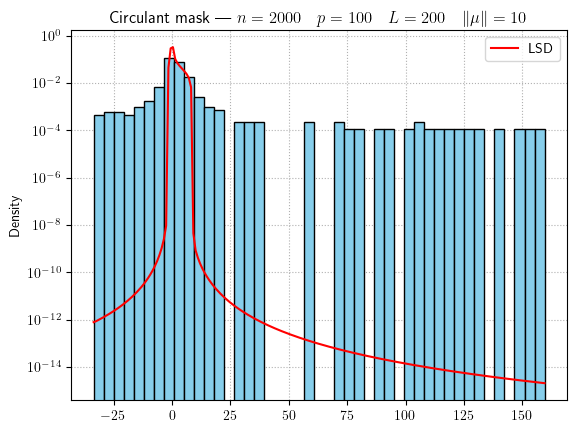

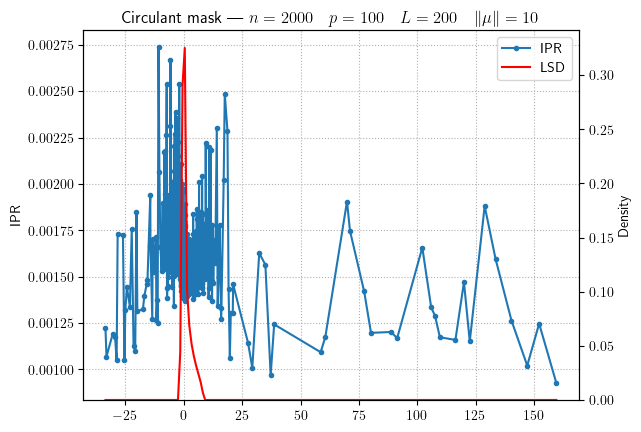

In [10]:
plt.hist(eigvals_c.flatten(), bins='sqrt', color='skyblue', edgecolor='black', density=True, zorder=2)
plt.plot(axr, LSD_c, color='red', label="LSD")
if pm1_setting:
    for spike in spikes_c:
        plt.axvline(x=spike, ls=':', color='green')
plt.grid(ls=':')
plt.yscale('log')
plt.ylabel("Density")
plt.legend()
plt.title("Circulant mask | "+setting)
plt.show()

plt.plot(eigvals_c[0], IPR_c[0], marker='.', label="IPR")
plt.grid(ls=':')
plt.ylabel("IPR")
ax1 = plt.gca()
ax2 = plt.twinx()
plt.plot(axr, LSD_c, color='red', label="LSD")
plt.ylabel("Density")
plt.ylim(bottom=0)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1+lines2, labels1+labels2)
plt.title("Circulant mask | "+setting)
plt.show()

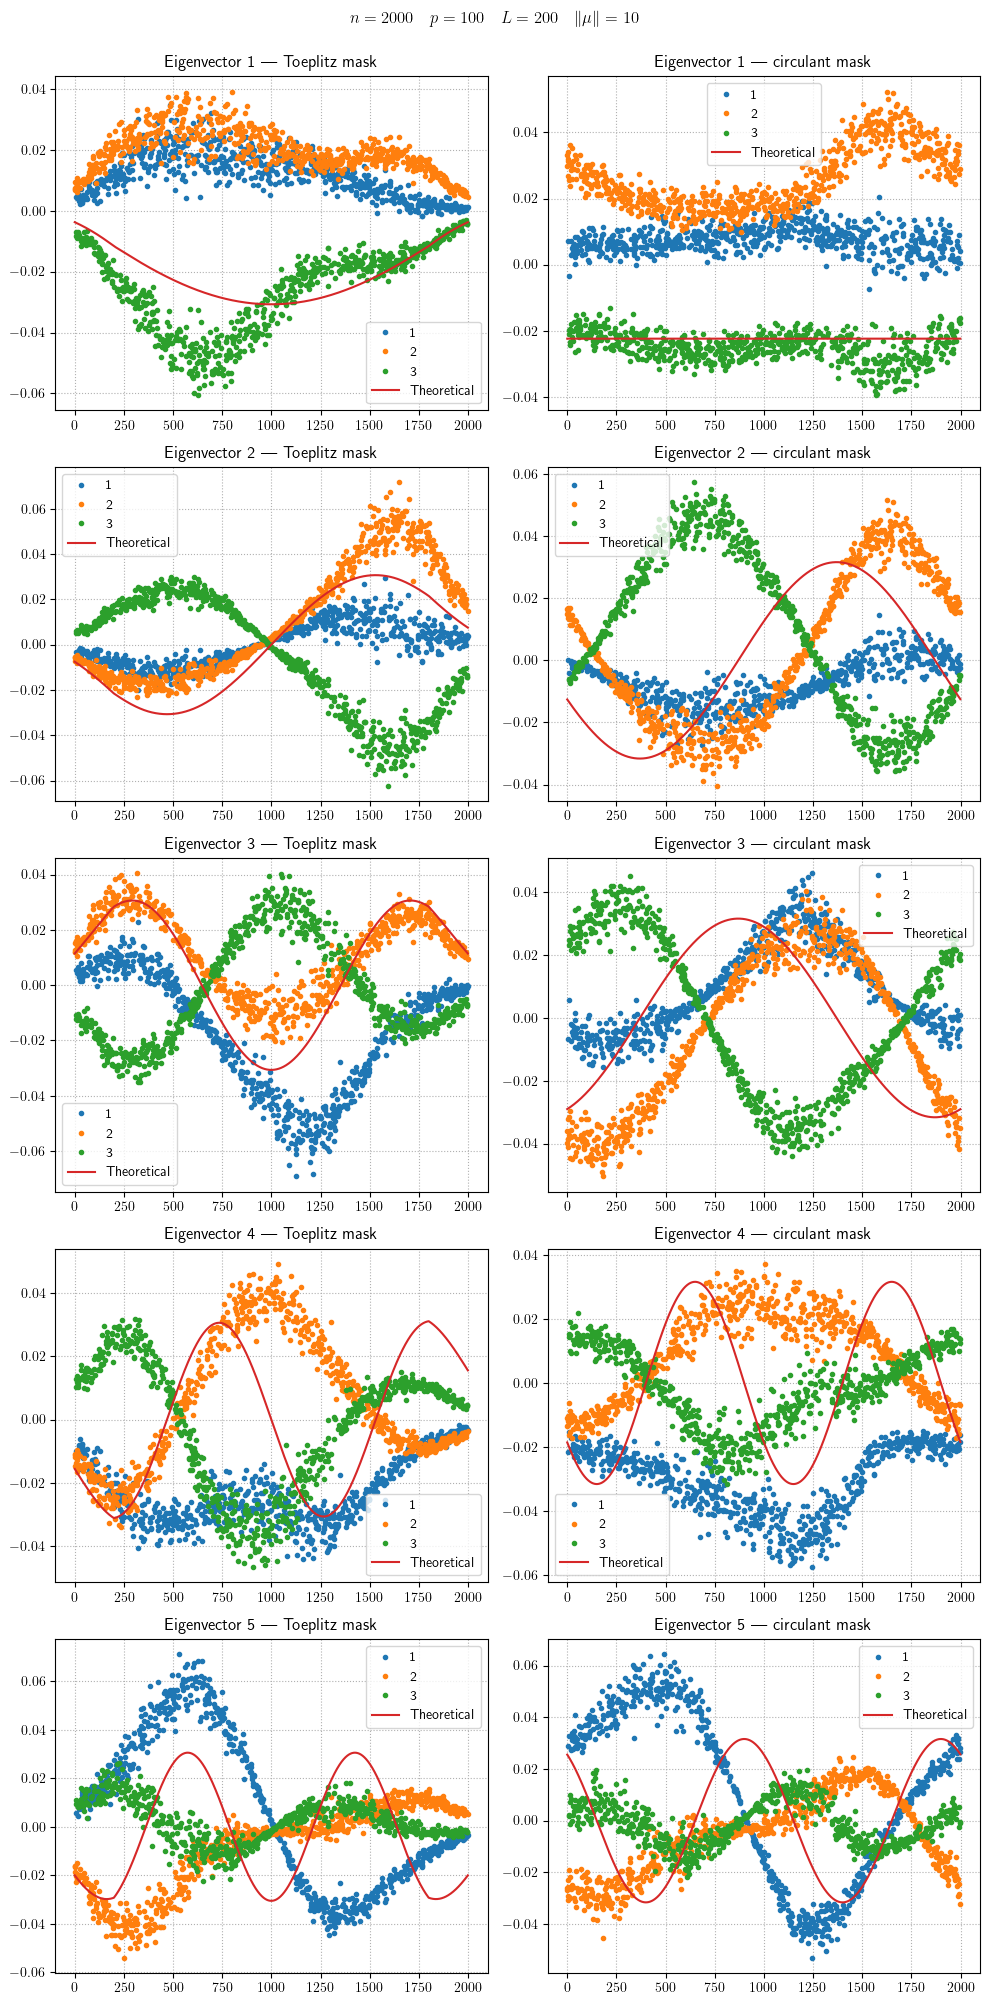

In [11]:
x = np.arange(n)
n_to_plot = 5
to_plot = spikes_idx_t[:n_to_plot] if pm1_setting else np.arange(n-1, n-1-n_to_plot, -1)

fig, ax = plt.subplots(n_to_plot, 2, figsize=(10, 4*n_to_plot), squeeze=False)
for ii, i in enumerate(to_plot):
    for j in range(k):
        cl = (J[:, j] == 1)
        ax[ii, 0].plot(x[cl], eigvecs_t[0, cl, i], ls='', marker='.', label=j+1)
        ax[ii, 1].plot(x[cl], eigvecs_c[0, cl, i], ls='', marker='.', label=j+1)
    ax[ii, 0].plot(x, basis_t[:, i], label="Theoretical")
    ax[ii, 1].plot(x, basis_c[:, i], label="Theoretical")
    ax[ii, 0].grid(ls=':')
    ax[ii, 1].grid(ls=':')
    ax[ii, 0].set_title("Eigenvector {} | Toeplitz mask".format(n-i))
    ax[ii, 1].set_title("Eigenvector {} | circulant mask".format(n-i))
    ax[ii, 0].legend()
    ax[ii, 1].legend()
fig.suptitle(setting, y=1)
fig.tight_layout()
plt.show()

# Classification

In [12]:
if pm1_setting:
    print("Optimal classification error: {:.2%}".format(stats.norm.sf(np.sqrt(zeta_t[0]/(1-zeta_t[0])))))

In [13]:
idx_eigvecs = list(range(n-5, n))[::-1] # eigenvectors used for the classification
# idx_eigvecs = np.argpartition(IPR_t[0], 5)[:5]
idx_basis = list(range(n-10, n)) # Toeplitz basis

In [14]:
partition, (exp_smooth, partition0, reg, curves) = utils.classification(k, eigvecs_t[0][:, idx_eigvecs], basis_t[:, idx_basis], correction=False)

In [15]:
c_err, per, per_inv = utils.get_classif_error(k, partition, np.argmax(J, axis=1))
print("Classification error: {:.2%}".format(c_err))

Classification error: 0.00%


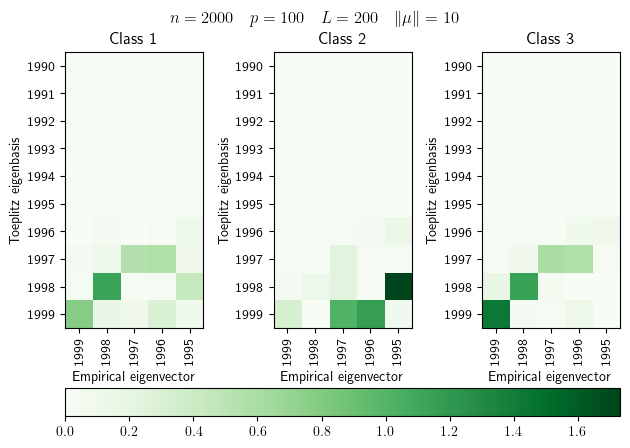

In [16]:
norm  = Normalize(0, np.max(reg**2))
fig, ax = plt.subplots(1, k)
for j in range(k):
    imshow = ax[j].imshow(reg[j]**2, interpolation='none', cmap='Greens', norm=norm)
    ax[j].set_xlabel("Empirical eigenvector")
    ax[j].set_xticks(ticks=range(reg[j].shape[1]))
    ax[j].set_xticklabels(idx_eigvecs, rotation=90)
    ax[j].set_ylabel("Toeplitz eigenbasis")
    ax[j].set_yticks(ticks=range(reg[j].shape[0]))
    ax[j].set_yticklabels(idx_basis)
    ax[j].set_title("Class {}".format(j+1))
fig.suptitle(setting)
fig.tight_layout()
fig.colorbar(imshow, ax=ax.ravel(), orientation='horizontal')
plt.show()

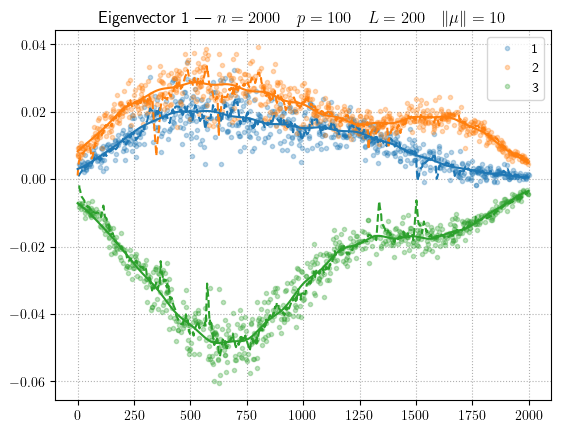

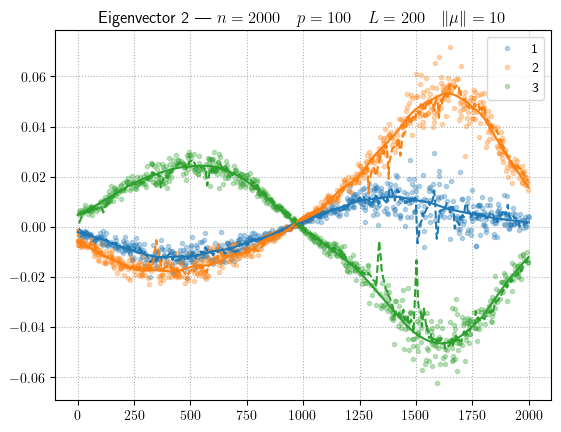

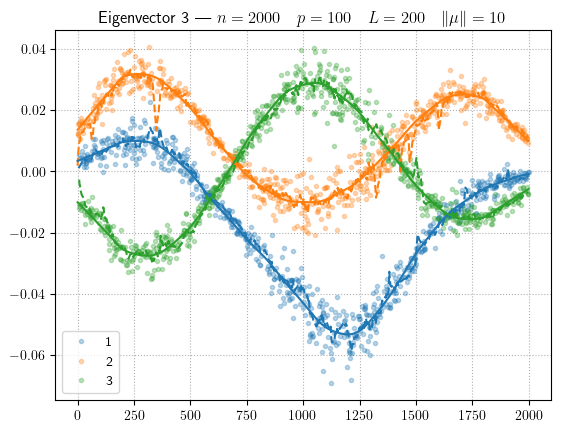

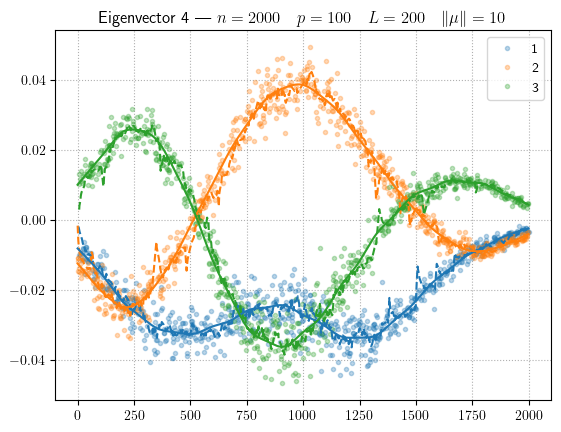

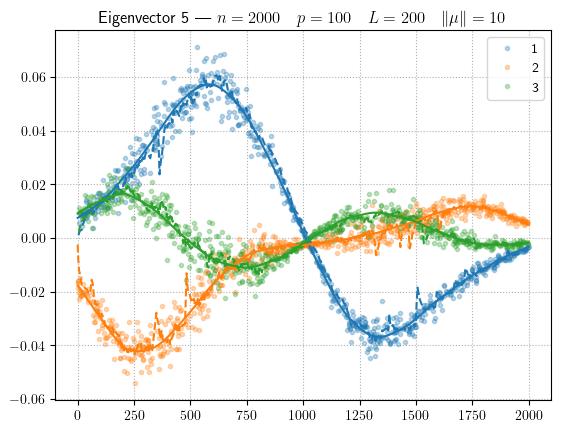

In [17]:
plot_true = True

x = np.arange(n)
for ll, l in enumerate(idx_eigvecs):
    for j in range(k):
        color = 'C'+str(j)
        cl = (J[:, j] == 1) if plot_true else (partition == j)
        plt.plot(x[cl], eigvecs_t[0, cl, l], ls='', marker='.', label=j+1, alpha=.3, c=color, zorder=2)
        plt.plot(x[partition0 == per_inv[j]], exp_smooth[partition0 == per_inv[j], ll], ls='--', c=color, zorder=3)
        plt.plot(x, curves[per_inv[j], :, ll], ls='-', c=color, zorder=4)
    plt.grid(ls=':')
    plt.legend()
    plt.title("Eigenvector {} | ".format((n-l)%n)+setting)
    plt.show()